# Init Environment

## Note

In [ ]:
# note of the module installations
# install python with pyenv (ref: https://github.com/lewagon/data-setup/blob/e5a239926f304d452704718136b6e2f017c7303d/macOS.md#installing-python-with-pyenv)
# setup virtual environment with pyenv (ref:https://github.com/lewagon/data-setup/blob/e5a239926f304d452704718136b6e2f017c7303d/macOS.md#installing-python-with-pyenv
# error: 'Failed to activate virtualenv' (ref:https://github.com/pyenv/pyenv-virtualenv/issues/387)
# pip install fasttext (0.9.2) (after installing the dependencies: numpy, scipy, pybind11, setuptools, wheel)

# install Jupyter notebook and nbextensions (ref: https://github.com/lewagon/data-setup/blob/e5a239926f304d452704718136b6e2f017c7303d/macOS.md#jupyter-notebook-extensions)
#   pip install jupyter_contrib_nbextensions
#   pip install --upgrade notebook==6.4.12 (ref:https://stackoverflow.com/questions/49647705/jupyter-nbextensions-does-not-appear)
#   pip install traitlets==5.9.0

## Import modules

In [ ]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from tqdm import tqdm
import concurrent.futures

import sys
sys.path.append('../')

from src.config import *
from src.helper_visualization import *
from src.helper_text import *
from src.helper_langID import *
from src.helper_translation import *
from src.helper_pred import *

# Combine Data Source

In [ ]:
import glob

# Get a list of file paths that match the pattern
files = glob.glob(f'{DATA_FOLDER_PATH_RAW}/data_202*.xlsx')
# Create an empty list to store DataFrames
dfs = []

# Loop through each file and read it into a DataFrame
for file in files:
    df = pd.read_excel(file, index_col=None)
    dfs.append(df)

# Concatenate the DataFrames into one
df_combined = pd.concat(dfs, ignore_index=True)
df_combined.info()

In [ ]:
#check for null values
df_combined.isnull().sum().sort_values(ascending = False)

In [ ]:
# columns which have large number of null values will be dropped 
columns_to_drop = [
    'Escalated To Engineering', 
    'Bug Type', 
    'Status Reason', 
    'Escalated to L2',
    'Category',
    'Completion Code'
]
try: 
    df_combined.drop(columns_to_drop, axis=1, inplace = True)
    df_combined.dropna(subset=['Request ID'], inplace=True)
    df_combined.dropna(subset=['Product Name'], inplace=True)
    df_combined.dropna(subset=['Title'], inplace=True)
except:
    pass
# surprisingly, there are over 100k duplications
df_combined.drop_duplicates(subset=['Title', 'Product Name'], keep='first', inplace=True)

In [ ]:
df_combined.isnull().sum().sort_values(ascending = False)

In [ ]:
# Specify the file name and path
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_combined.xlsx'

# Export the DataFrame to Excel
df_combined.to_excel(excel_file, index=False)  # Set index to False if you don't want to export the DataFrame index

# Load Data for Pre-processing

In [ ]:
if 'df_combined' not in locals():
    data_url = f'{DATA_FOLDER_PATH_PROCESSED}/data_combined.xlsx'
    df_combined = pd.read_excel(data_url, index_col=None)
print(df_combined.info())

# Clean-up the Title Column

## Quick Clean-up

In [ ]:
df_processed = df_combined.copy()

# Delete unnecessary columns, add needed columns
df_processed.drop(columns=[
    'Created Time', 
    'Customer Company', 'Customer Country', 
    'Priority', 'Urgency', 'Impact', 
    'Service Definition', 'Service Desk Group', 'Status',
    'Closed Time', 
    'Response Time (Min)', 'Resolution Time (Min)', 
    'Contracts Reference', 'Creation Source'
    ], inplace=True)

# Add new columns
df_processed['Title_Processed']=pd.NA
df_processed['Language']=pd.NA
df_processed['Length'] = 0
df_processed['Title_Translated']=pd.NA
df_processed['Title_Enhanced']=pd.NA
df_processed['Tags']=pd.NA


# Run quick clean up on the 'Title' column and save the result to the 'Title_Processed' column

# Set the number of rows to process
num = df_processed['Title'].notnull().sum()

# Initialize a progress bar with the total number of rows
progress_bar = tqdm(total=num, desc="Processing Rows", unit=" row")

# Function to process a single row and update the 'Processed_Title' column
def process_row(index):
    # processed_title = preprocess_step_1(df_combined.at[index, 'Title'])
    processed_title = quick_clean_up(df_processed.at[index, 'Title'])
    df_processed.at[index, 'Title_Processed'] = processed_title
    df_processed.at[index, 'Length'] = count_words(processed_title)
    progress_bar.update(1)

# Define the number of parallel workers (adjust this based on your CPU cores)
num_workers = 8

# Create a ThreadPoolExecutor with the specified number of workers
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Use the executor to process rows in parallel
    executor.map(process_row, df_processed.index)

# Close the progress bar
progress_bar.close()

# Delete records with missing values in 'Title_Processed' columns
df_processed.dropna(subset=['Title_Processed'], inplace=True)

# Remove duplicates based on 'Title_Processed' and 'ProductName' columns
df_processed.drop_duplicates(subset=['Title_Processed', 'Product Name'], keep='first', inplace=True)

print(df_processed.info())
hist_by_labels(df_processed, 'Length', log=False)

df_processed.head(30)

## Language Detection

In [ ]:
# Run language detection on the 'Title_Processed' column and save the result to the 'Language' column
# This is the step required to run bulk language translation using Google Translate API for performance reason
# The language detection is done using FastText library since FastText is better than the langdetect library and other options.
# ref: https://medium.com/besedo-engineering/language-identification-for-very-short-texts-a-review-c9f2756773ad
# FastText has difficulty detecting CJK languages mixed with English, so we will use udf-8 encoding to detect CJK languages directly.

# Set the number of rows to process
num = df_processed['Title_Processed'].notnull().sum()

# df['Title_Translated'] = df['Title_Processed']
# Initialize a progress bar with the total number of rows
progress_bar = tqdm(total=num, desc="Processing Rows", unit=" row")

# Function to process a single row and update the 'Processed_Title' column
def process_row(index):
    df_processed.at[index, 'Language'] = detect_language_fasttext(df_processed.at[index, 'Title_Processed'])
    progress_bar.update(1)

# Define the number of parallel workers (adjust this based on your CPU cores)
num_workers = 8

# Create a ThreadPoolExecutor with the specified number of workers
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Use the executor to process rows in parallel
    executor.map(process_row, df_processed.index)

# Close the progress bar
progress_bar.close()

hist_by_labels(df_processed, "Language", log=True, horizontal=True, left=10.5)

print(f"Language detected with low confidence: \033[94m{df_processed['Language'].value_counts(normalize=True)['unknown'] * 100:.3f}%\033[0m.")
df_processed.head(20)

In [ ]:
# Keep the top 10 languages and drop the rest and the unknown. 
# why? There are high chances the detected language were not correct due to wrong spelling, etc.
language_counts = df_processed['Language'].value_counts()
cutoff = 90
language_others = language_counts.index[language_counts < cutoff]

mask_others = df_processed['Language'].isin(language_others)
df_processed.loc[mask_others,'Language']='unknown'

# Drop rows where 'Language' is equal to 'unknown'
df_detection_unknown = df_processed[df_processed['Language'] == 'unknown']
df_processed = df_processed[df_processed['Language'] != 'unknown']

print(f"Language detected with low confidence: \033[94m{df_detection_unknown.shape[0]}\033[0m.")
print(df_translated.info())

In [ ]:
# Save the DataFrame to Excel for future steps without having to run the previous steps again
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_processed.xlsx'
df_processed.to_excel(excel_file, index=False)  # Set index to False if you don't want to export the DataFrame index
print(f'\033[94m{excel_file}\033[0m saved')

excel_file_unknown = f'{DATA_FOLDER_PATH_PROCESSED}/data_langID_unknown.xlsx'
df_detection_unknown.to_excel(excel_file_unknown, index=False)
print(f'\033[94m{excel_file_unknown}\033[0m saved')

In [ ]:
hist_by_labels(df_detection_unknown, "Length", log=False)

## Translation of Non-English

In [ ]:
# Translate the 'Title_Processed' column and save the result to the 'Title_Translated' column
# language by language to avoid Google Translate API quota limit
# skip English obviously
# the length limit is 1250 characters due to Google Translate API limit for CJK languages
# load the processed data df_processed if not loaded yet
if 'df_processed' not in locals():
    excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_processed.xlsx'
    df_processed = pd.read_excel(excel_file)

df_translated = df_processed.copy()
df_translated['Title_Translated'] = df_translated['Title_Processed']

grouped = df_translated.groupby("Language")

# Initialize tqdm to display progress bar
pbar = tqdm(total=len(grouped), desc=f"Translating")

# Create an empty list to store the processed groups
processed_groups = []

# Iterate through sub DataFrames
for lang, group in grouped:
    pbar.set_description(f"Processing [\033[94m{lang}/{len(group)}\033[0m]")

    translated_titles = translate_array(
        group["Title_Translated"].tolist(),
        src_lang=lang,
        tar_lang='en',
        length_limit=1250)
    group["Title_Translated"] = translated_titles  # Update "Title_Translated" column in the group
    
    processed_groups.append(group)
    pbar.update(1)  # Update the progress bar

# Close the progress bar
pbar.close()

# Concatenate the groups back into a single DataFrame
df_translated = pd.concat(processed_groups, ignore_index=True)

In [ ]:
# Delete records with missing values in 'Title_Translated' columns
# there should be no missing values in 'Title_Translated' columns but just in case
df_translated.dropna(subset=['Title_Translated'], inplace=True)

# remove the confusion between Petrel and Petrel RE
df_translated['Title_Translated'] = df_translated['Title_Translated'].str.replace('petrel re', 'PetrelRE', case=False)

# Remove duplicates based on 'Title_Translated' and 'Product Name' columns
df_translated.drop_duplicates(subset=['Title_Translated', 'Product Name'], keep='first', inplace=True)

print(df_translated.info())
df_translated.head(20)

In [ ]:
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_translated.xlsx'
df_translated.to_excel(excel_file, index=False)  # Set index to False if you don't want to export the DataFrame index
print(f'\033[94m{excel_file}\033[0m saved')

## Enhance Title

In [6]:
if 'df_translated' not in locals():
    excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_translated.xlsx'
    df_translated = pd.read_excel(excel_file)

df_enhanced = df_translated.copy()
# Set the number of rows to process
num = df_enhanced['Title_Translated'].notnull().sum()
df_enhanced['Title_Enhanced'] = ""
# Initialize a progress bar with the total number of rows
progress_bar = tqdm(total=num, desc="Processing Rows", unit=" row")

# Function to process a single row and update the 'Processed_Title' column
def process_row(index):
    df_enhanced.at[index, 'Title_Enhanced'] = enhance_title(df_enhanced.at[index, 'Title_Translated'])
    progress_bar.update(1)

# Define the number of parallel workers (adjust this based on your CPU cores)
num_workers = 8

# Create a ThreadPoolExecutor with the specified number of workers
with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
    # Use the executor to process rows in parallel
    executor.map(process_row, df_enhanced.index)

# Close the progress bar
progress_bar.close()

print(df_cleaned.info())
df_translated.to_excel(excel_file, index=False)  # Set index to False if you don't want to export the DataFrame index
display(df_enhanced.head(20))

excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_enhanced.xlsx'
df_enhanced.to_excel(excel_file, index=False)  # Set index to False if you don't want to export the DataFrame index
print(f'\033[94m{excel_file}\033[0m has been saved.')

Processing Rows: 100%|██████████| 134883/134883 [00:17<00:00, 7728.92 row/s]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134883 entries, 0 to 134882
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Request ID        134883 non-null  int64  
 1   Title             134883 non-null  object 
 2   Product Name      134883 non-null  object 
 3   Module Name       126636 non-null  object 
 4   Title_Processed   134883 non-null  object 
 5   Language          134883 non-null  object 
 6   Length            134883 non-null  int64  
 7   Title_Translated  134883 non-null  object 
 8   Title_Enhanced    134757 non-null  object 
 9   Tags              0 non-null       float64
dtypes: float64(1), int64(2), object(7)
memory usage: 10.3+ MB
None


,Request ID,Title,Product Name,Module Name,Title_Processed,Language,Length,Title_Translated,Title_Enhanced,Tags
0,1570587,[Ext] DDR,Petrel,GCCore,DDR,de,1,GDR,GDR,NaN
1,1411222,TRANZ,Petrel RE,RE - History Match Analysis,TRANZ,de,1,TRANCE,TRANCE,NaN
2,1173587,OpenGL error message,Petrel,User Experience,OpenGL error,de,2,OpenGL error,OpenGL,NaN
3,1350927,Petrel datum,Petrel,Geophysics Core,Petrel datum,de,2,Petrel date,Petrel date,NaN
4,1474719,SFM TR3-CONVERT,Ocean Plug-ins for Petrel - WG,WesternGeco Earth Model Building,SFM,de,1,SFM,SFM,NaN
5,1360682,Export PDF,Techlog,Techplot,Export PDF,de,2,Export PDF,Export PDF,NaN
6,1375234,Loading PDF,Techlog,Techplot,Loading PDF,de,2,Loading PDF,Loading PDF,NaN
7,1127537,Issue - BIS,OLGA,High Definition,Issue BIS,de,2,Issue UNTIL,Issue,NaN
8,1482503,DEM import into PETREL 2021,Petrel,Geophysics Core,DEM import into PETREL,de,4,DEM import into PETREL,DEM import PETREL,NaN
9,1187942,WCS SAUDI <HAl-shams@slb.com> PT BOB,RigHour,Others,WCS SAUDI PT BOB,de,4,WCS SAUDI PT BOB,well construction ( WCS ) PT BOB,NaN


../data/processed/data_enhanced.xlsx has been saved.


## Extract Tags

In [7]:
if 'df_enhanced' not in locals():
    excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_enhanced.xlsx'
    df_enhanced = pd.read_excel(excel_file , dtype={'Request ID': str, 'Title_Cleaned': str})

df_cleaned = df_enhanced.copy()
print(df_cleaned.info())
df_cleaned.head(10)

# Set the number of rows to process
num = df_cleaned['Title_Enhanced'].notnull().sum()
df_cleaned['Tags'] = ""
# Initialize a progress bar with the total number of rows
progress_bar = tqdm(total=num, desc="Processing Rows", unit=" row")

# Function to process a single row and update the 'Processed_Title' column
def process_row(index):
    df_cleaned.at[index, 'Tags'] = extract_keywords(df_cleaned.at[index, 'Title_Enhanced'])
    df_cleaned.at[index, 'Length'] = count_words(df_cleaned.at[index, 'Title_Enhanced'])
    progress_bar.update(1)

# Define the number of parallel workers (adjust this based on your CPU cores)
num_workers = 8

# Create a ThreadPoolExecutor with the specified number of workers
with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
    # Use the executor to process rows in parallel
    executor.map(process_row, df_cleaned.index)

# Close the progress bar
progress_bar.close()

# Remove duplicates based on 'Title' and 'ProductName' columns after translation
df_cleaned.dropna(subset=['Tags'], inplace=True)
df_cleaned.drop_duplicates(subset=['Tags', 'Product Name'], keep='first', inplace=True)
print(df_cleaned.info())

# remove the same title pointing to multiple products
n_title = df_cleaned['Tags'].value_counts()
good_title = n_title.index[n_title == 1]
print (len(good_title))

mask = df_cleaned['Tags'].isin(good_title)
df_cleaned = df_cleaned[mask]
print(df_cleaned.info())
print(df_cleaned.isnull().sum().sort_values(ascending = False))
display(df_cleaned.head(20))
# Specify the file name and path
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_cleaned.xlsx'
df_cleaned.to_excel(excel_file, index=False)  # Set index to False if you don't want to export the DataFrame index
print(f'\033[94m{excel_file}\033[0m has been saved.')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134883 entries, 0 to 134882
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Request ID        134883 non-null  int64  
 1   Title             134883 non-null  object 
 2   Product Name      134883 non-null  object 
 3   Module Name       126636 non-null  object 
 4   Title_Processed   134883 non-null  object 
 5   Language          134883 non-null  object 
 6   Length            134883 non-null  int64  
 7   Title_Translated  134883 non-null  object 
 8   Title_Enhanced    134757 non-null  object 
 9   Tags              0 non-null       float64
dtypes: float64(1), int64(2), object(7)
memory usage: 10.3+ MB
None


Processing Rows: 100%|█████████▉| 134750/134757 [00:21<00:00, 6346.10 row/s]


<class 'pandas.core.frame.DataFrame'>
Index: 125189 entries, 0 to 134882
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Request ID        125189 non-null  int64 
 1   Title             125189 non-null  object
 2   Product Name      125189 non-null  object
 3   Module Name       117779 non-null  object
 4   Title_Processed   125189 non-null  object
 5   Language          125189 non-null  object
 6   Length            125189 non-null  int64 
 7   Title_Translated  125189 non-null  object
 8   Title_Enhanced    125189 non-null  object
 9   Tags              125189 non-null  object
dtypes: int64(2), object(8)
memory usage: 10.5+ MB
None
119129
<class 'pandas.core.frame.DataFrame'>
Index: 119129 entries, 1 to 134882
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Request ID        119129 non-null  int64 
 1   Title          

,Request ID,Title,Product Name,Module Name,Title_Processed,Language,Length,Title_Translated,Title_Enhanced,Tags
1,1411222,TRANZ,Petrel RE,RE - History Match Analysis,TRANZ,de,1,TRANCE,TRANCE,trance
8,1482503,DEM import into PETREL 2021,Petrel,Geophysics Core,DEM import into PETREL,de,3,DEM import into PETREL,DEM import PETREL,import dem petrel
9,1187942,WCS SAUDI <HAl-shams@slb.com> PT BOB,RigHour,Others,WCS SAUDI PT BOB,de,5,WCS SAUDI PT BOB,well construction ( WCS ) PT BOB,pt well construction bob wcs
10,1256767,Tungsten : Survey,RTDS,Other,Tungsten Survey,de,2,Tungsten Survey,Tungsten Survey,tungsten survey
11,1422462,Tungsten : Patch HD,RTDS,Other,Tungsten Patch HD,de,3,Tungsten Patch HD,Tungsten Patch HD,patch tungsten hd
12,1499176,X-00SMCX | [Ext] OFM Package Delfi Won’t Open,Petrotechnical Suite - Domain Profiles,OFM,OFM Package Delfi Won’t Open,de,7,OFM Package Delfi Won’t Open,oil field management ( OFM ) Package Delfi ’ Open,ofm field oil package delfi open ’ management
13,1544450,Tungsten : Zeus-1 Torque Data,RTDS,Other,Tungsten Torque Data,de,3,Tungsten Torque Data,Tungsten Torque Data,tungsten data torque
14,1569769,Tungsten : Viewer 12.5,RTDS,Other,Tungsten Viewer .,de,2,Tungsten Viewer.,Tungsten Viewer,viewer tungsten
15,1657126,S12K : Change well to Baleine 1 Bis,RTDS,Other,Change well to Baleine Bis,de,4,Change well to Baleine Bis,Change well Baleine Bis,change well bi baleine
16,1726185,Saipem12K: Redirect to Baleine 1 BIS 17.5in,RTDS,Other,Redirect to Baleine BIS .,de,3,Redirect to Baleine BIS .,Redirect Baleine BIS,bi baleine redirect


../data/processed/data_cleaned.xlsx has been saved.


# Consolidate Product Categories

<class 'pandas.core.frame.DataFrame'>
Index: 119129 entries, 1 to 134882
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Request ID        119129 non-null  int64 
 1   Title             119129 non-null  object
 2   Product Name      119129 non-null  object
 3   Module Name       112436 non-null  object
 4   Title_Processed   119129 non-null  object
 5   Language          119129 non-null  object
 6   Length            119129 non-null  int64 
 7   Title_Translated  119129 non-null  object
 8   Title_Enhanced    119129 non-null  object
 9   Tags              119129 non-null  object
dtypes: int64(2), object(8)
memory usage: 10.0+ MB
None


,Request ID,Title,Product Name,Module Name,Title_Processed,Language,Length,Title_Translated,Title_Enhanced,Tags
1,1411222,TRANZ,Petrel RE,RE - History Match Analysis,TRANZ,de,1,TRANCE,TRANCE,trance
8,1482503,DEM import into PETREL 2021,Petrel,Geophysics Core,DEM import into PETREL,de,3,DEM import into PETREL,DEM import PETREL,import dem petrel
9,1187942,WCS SAUDI <HAl-shams@slb.com> PT BOB,RigHour,Others,WCS SAUDI PT BOB,de,5,WCS SAUDI PT BOB,well construction ( WCS ) PT BOB,pt well construction bob wcs
10,1256767,Tungsten : Survey,RTDS,Other,Tungsten Survey,de,2,Tungsten Survey,Tungsten Survey,tungsten survey
11,1422462,Tungsten : Patch HD,RTDS,Other,Tungsten Patch HD,de,3,Tungsten Patch HD,Tungsten Patch HD,patch tungsten hd
...,...,...,...,...,...,...,...,...,...,...
134865,857757,Phone-关于FM的几点说明,Petrel RE,RE - Intersect Connector,Phone 关于 FM 的几点说明,zh,4,Phone A few notes about FM,Phone notes forward modeling,note modeling forward phone
134866,859952,Phone-FM更新历史数据模拟结果异常,INTERSECT,INTERSECT Simulator,Phone FM 更新历史数据模拟结果异常,zh,9,Phone FM updates historical data simulation re...,Phone forward modeling updates historical data...,data forward abnormal simulation historical mo...
134867,885444,Phone-重启预测操作,INTERSECT,INTERSECT Simulator,Phone 重启预测操作,zh,4,Phone restarts prediction operation,Phone restarts prediction operation,operation prediction restarts phone
134868,940253,Phone-IX 重启错误问题,INTERSECT,INTERSECT Simulator,Phone IX 重启错误问题,zh,3,Phone IX restart error problem,Phone Intersect restart,restart intersect phone


<class 'pandas.core.frame.DataFrame'>
Index: 116740 entries, 1 to 134882
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Request ID        116740 non-null  int64 
 1   Title             116740 non-null  object
 2   Product Name      116740 non-null  object
 3   Title_Processed   116740 non-null  object
 4   Language          116740 non-null  object
 5   Length            116740 non-null  int64 
 6   Title_Translated  116740 non-null  object
 7   Title_Enhanced    116740 non-null  object
 8   Tags              116740 non-null  object
dtypes: int64(2), object(7)
memory usage: 8.9+ MB
None


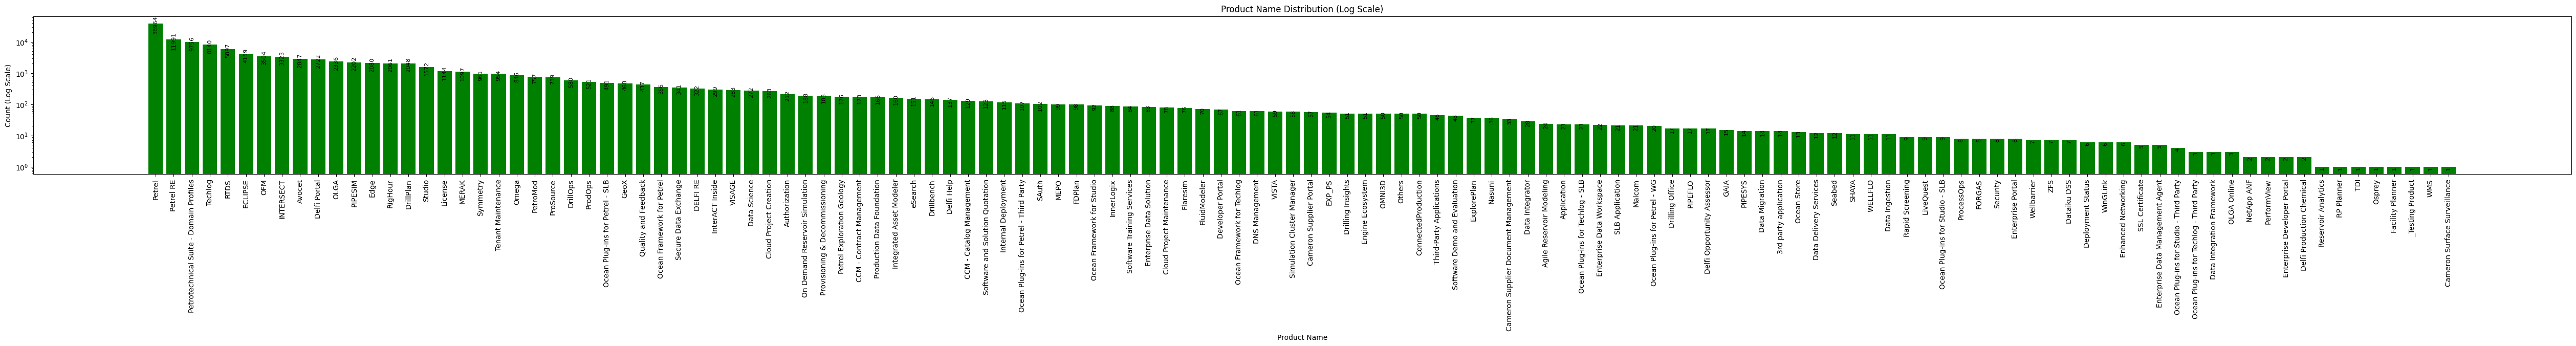

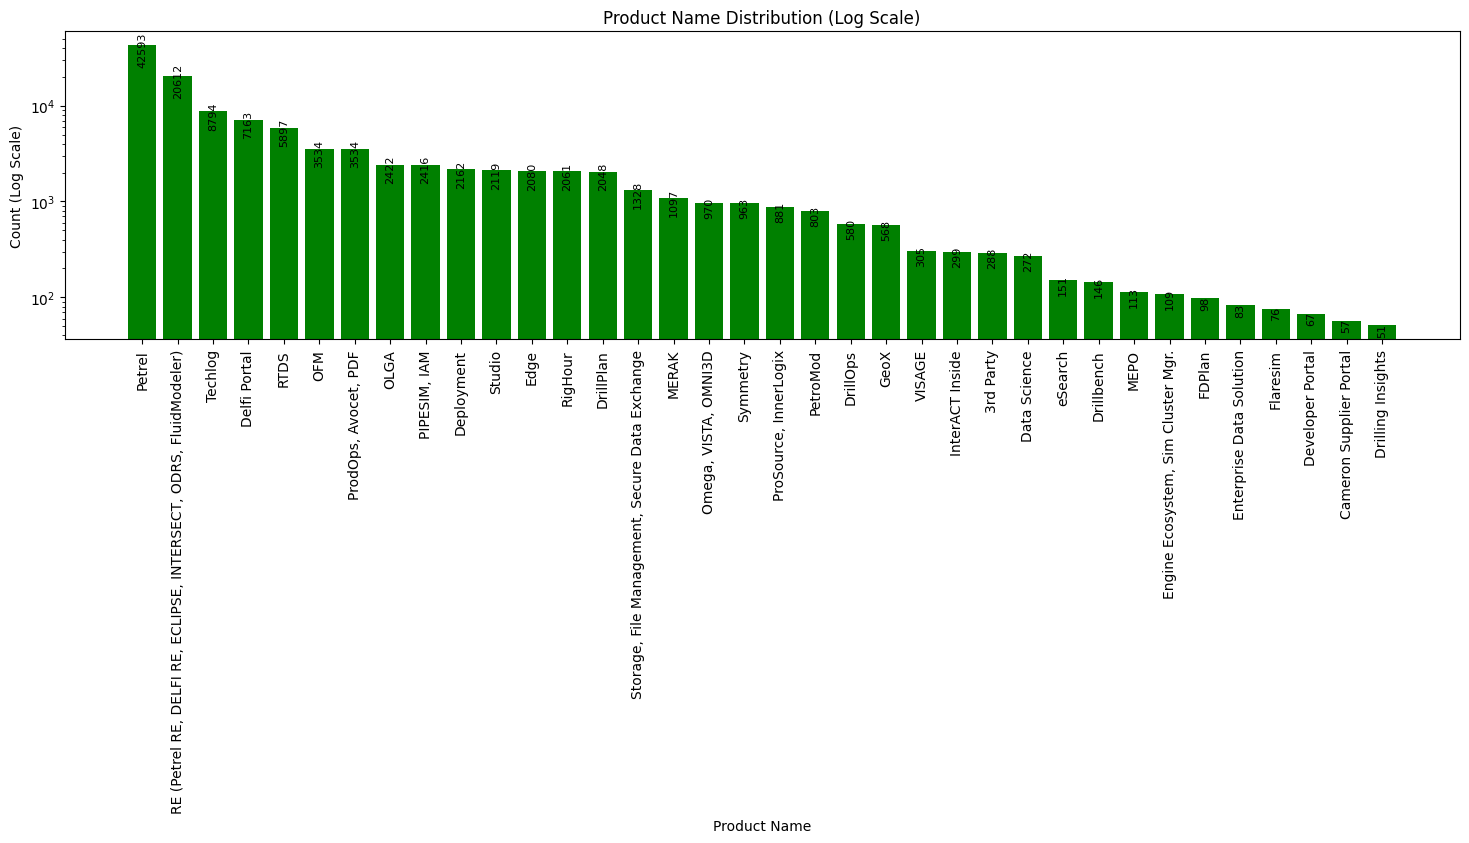

../data/processed/data_consolidated.xlsx has been saved.
../data/processed/data_train.xlsx has been saved.
../data/processed/data_test.xlsx has been saved.


In [8]:
if 'df_cleaned' not in locals():
    excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_cleaned.xlsx'
    df_cleaned = pd.read_excel(excel_file , dtype={'Request ID': str, 'Title_Cleaned': str})
print(df_cleaned.info())

df_consolidated = df_cleaned.copy()
display(df_consolidated.head(-10))

dict_category_mapping = {
    'Others': ['Other'],
    'Studio': ['Ocean Framework for Studio'],
    'Techlog': ['Ocean Framework for Techlog'],
    'PIPESIM, IAM': ['PIPESIM', 'Integrated Asset Modeler'],
    'Omega, VISTA, OMNI3D': ['Omega', 'OMEGA', 'VISTA', 'OMNI3D'],
    'ProSource, InnerLogix': ['ProSource', 'EXP_PS', 'InnerLogix'],
    'ProdOps, Avocet, PDF': ['ProdOps', 'Production Data Foundation', 'Avocet'],
    'Engine Ecosystem, Sim Cluster Mgr.': ['Engine Ecosystem', 'Simulation Cluster Manager'],
    'Petrel': ['Petrel Exploration Geology', 'Petrel Project Explorer', 'Ocean Framework for Petrel', 'Ocean Plug-ins for Petrel - SLB'],
    'Storage, File Management, Secure Data Exchange': ['Storage', 'Nasuni', 'File Management', 'Secure Data Exchange'],
    'Delfi Portal': ['Delfi Portal', 'SAuth', 'License', 'Licensing', 'Environment', 'Authorization', 'VM', 'TGX', 'Remote App'],
    'RE (Petrel RE, DELFI RE, ECLIPSE, INTERSECT, ODRS, FluidModeler)': ['Petrel RE', 'DELFI RE', 'ECLIPSE', 'INTERSECT', 'On Demand Reservoir Simulation', 'FluidModeler'],
    
    '3rd Party': ['Ocean Plug-ins for Petrel - Third party', 'Ocean Plug-ins for Petrel - Third Party',
                '3rd party application', 'Third-Party Applications', 'Ocean Plug-ins for Techlog - Third Party', 
                'App – Third Party', 'App - Third Party'],
    
    'Deployment': ['Provisioning & Decommissioning', 'Software Demo and Evaluation', 'Internal Deployment', 'Image', 
                'Deployment Status', "New PTS Deployment", 'Remove PTS Deployment', 'System Deployment', 'Deployment',
                'Cloud Project Creation', 'Cloud Project Maintenance', 'Tenant Maintenance', 'DNS Management',
                'CCM - Contract Management', 'CCM - Catalog Management', 'Software and Solution Quotation']
}
# Use Module Name to replace Product Name for all 'Petrotechnical Suite - Domain Profiles'

df_consolidated.loc[df_consolidated['Product Name'] == 'Petrotechnical Suite - Domain Profiles', 'Product Name'] = df_consolidated['Module Name']
df_consolidated.drop(columns=['Module Name'], inplace=True)
df_consolidated.dropna(subset=['Product Name'], inplace=True)

# combine the following products into corresponding categories
for category, products in dict_category_mapping.items():
    df_consolidated.loc[df_consolidated['Product Name'].isin(products), 'Product Name'] = category

#drop the rows which Product Name is 'Quality and Feedback' and 'Software Training Services'
df_consolidated = df_consolidated[df_consolidated['Product Name'] != 'Others']
df_consolidated = df_consolidated[df_consolidated['Product Name'] != 'Delfi Help']
df_consolidated = df_consolidated[df_consolidated['Product Name'] != 'Quality and Feedback']
df_consolidated = df_consolidated[df_consolidated['Product Name'] != 'Software Training Services']

#Drop the products which have less than 50 records
df_consolidated = df_consolidated.groupby('Product Name').filter(lambda x : len(x)>50)

print(df_consolidated.info())

hist_by_labels(df_cleaned, 'Product Name', log=True, horizontal=True)
hist_by_labels(df_consolidated, 'Product Name', top=None, log=True, horizontal=True)

from sklearn.model_selection import train_test_split

# Specify the file name and path
excel_file_consolidated = f'{DATA_FOLDER_PATH_PROCESSED}/data_consolidated.xlsx'
excel_file_train = f'{DATA_FOLDER_PATH_PROCESSED}/data_train.xlsx'
excel_file_test = f'{DATA_FOLDER_PATH_PROCESSED}/data_test.xlsx'

# split the data into train and test sets with 90% and 10% respectively of each product
df_train, df_test = train_test_split(df_consolidated, test_size=0.1, random_state=42, stratify=df_consolidated['Product Name'])

# Export the DataFrame to Excel
df_consolidated.to_excel(excel_file_consolidated, index=False)  # Set index to False if you don't want to export the DataFrame index
print(f'\033[94m{excel_file_consolidated}\033[0m has been saved.')
df_train.to_excel(excel_file_train, index=False)  # Set index to False if you don't want to export the DataFrame index
print(f'\033[94m{excel_file_train}\033[0m has been saved.')
df_test.to_excel(excel_file_test, index=False)  # Set index to False if you don't want to export the DataFrame index
print(f'\033[94m{excel_file_test}\033[0m has been saved.')

# Data Augmentation

In [ ]:
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_train.xlsx'

df_train = pd.read_excel(excel_file , dtype={'Request ID': str, 'Title_Cleaned': str})
print(df_train.info())
hist_by_labels(df_train, 'Product Name', top=None, log=True, horizontal=True)

In [ ]:
# function to augment a dataframe with a given product name
def augment_product_data(df, target_size=500):

    result = pd.DataFrame(columns=df.columns)
    
    df_size = len(df)
    lang_agent = ['fr', 'ja', 'ru', 'es', 'ko', 'zh', 'pt', 'ar', 'de', 'it']
    
    num_iterations = min(target_size // df_size-1, len(lang_agent))
    
    for i in range(num_iterations):
        df_temp = df.copy()
        translated_titles = df_temp["Title_Translated"].tolist()
        translated_titles = translate_array(translated_titles, src_lang='en', tar_lang=lang_agent[i],length_limit=1250)
        translated_titles = translate_array(translated_titles, src_lang=lang_agent[i], tar_lang='en',length_limit=1250)

        df_temp['Title_Translated'] = translated_titles
        result = pd.concat([result, df_temp], ignore_index=True)
    return result

TARGET_SIZE = 5000
df_augmented = pd.DataFrame(columns=df_train.columns)

# filter the products which have less than 2500 records
grouped = df_train.groupby("Product Name")
# grouped = grouped.filter(lambda x : len(x)>2500)

# Initialize tqdm to display progress bar
pbar = tqdm(total=len(grouped), desc=f"Processing")

# Create an empty list to store the processed groups
processed_groups = []

# Iterate through sub DataFrames
for product, group in grouped:
    if (len(group) > TARGET_SIZE//2):
        pbar.update(1)  # Update the progress bar
        continue
    pbar.set_description(f"Processing [{product}/{len(group)}]")
    df_product = augment_product_data(group, target_size=TARGET_SIZE)

    processed_groups.append(df_product)
    pbar.update(1)  # Update the progress bar
# Close the progress bar
pbar.close()

# Concatenate the groups back into a single DataFrame
df_additional = pd.concat(processed_groups, ignore_index=True)
df_augmented = pd.concat([df_augmented, df_additional], ignore_index=True)


In [ ]:
results = df_augmented.copy()

df_augmented = pd.concat([df_train, df_augmented], ignore_index=True)

In [ ]:
print(results.info())
df_augmented.info()

In [ ]:
df_augmented['Title_Cleaned'] = df_augmented['Title_Translated'].apply(final_clean_up)
df_augmented.dropna(subset=['Title_Cleaned'], inplace=True)
df_augmented['Length'] = df_augmented['Title_Cleaned'].apply(count_words)
df_augmented.drop_duplicates(subset=['Title_Cleaned', 'Product Name'], keep='first', inplace=True)
df_augmented.drop_duplicates(subset=['Title_Cleaned'], inplace=True)

print(df_train.info())
print(df_augmented.info())

hist_by_labels(df_train, 'Product Name', top=None, log=True, horizontal=True)
hist_by_labels(df_augmented, 'Product Name', top=None, log=True, horizontal=True)

In [ ]:

# Specify the file name and path
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_augmented.xlsx'

# Export the DataFrame to Excel
df_augmented.to_excel(excel_file, index=False)  # Set index to False if you don't want to export the DataFrame index